In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import gc

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import lightgbm as lgb

Using TensorFlow backend.


In [2]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [3]:
X_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test  = pd.read_csv('../input/X_test.csv')

In [4]:
targets = y_train['surface'].value_counts().index
print(targets)
print(y_train['surface'].value_counts())

Index(['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete',
       'hard_tiles_large_space', 'soft_tiles', 'carpet', 'hard_tiles'],
      dtype='object')
concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


In [5]:
target_to_id = {}
id_to_target = {}

for target in targets:
    if target not in target_to_id:
        new_id = len(target_to_id)
        target_to_id[target] = new_id
        id_to_target[new_id] = target

In [6]:
y_id = []
for i in range(len(y_train)):
    y_id.append(target_to_id[y_train['surface'].values[i]])
y_id = np.asarray(y_id)

In [7]:
class_num = len(targets)

In [8]:
y_id_one = np.zeros((len(y_id), class_num))
for i in range(len(y_id)):
    y_id_one[i, y_id[i]] = 1 

In [9]:
def norm_quat(df):
    norm = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 + df['orientation_W']**2)**0.5
    df['orientation_X'] /= norm
    df['orientation_Y'] /= norm
    df['orientation_Z'] /= norm
    df['orientation_W'] /= norm
    return df

In [10]:
import math

def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

X_train = norm_quat(X_train)
X_test = norm_quat(X_test)

In [11]:
def fe_step1 (df):
    """Quaternions to Euler Angles"""
    
    x = df['orientation_X'].values
    y = df['orientation_Y'].values
    z = df['orientation_Z'].values
    w = df['orientation_W'].values
    nx, ny, nz = np.zeros(len(x)), np.zeros(len(y)), np.zeros(len(z)),
    for i in tqdm(range(len(x))):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx[i] = xx
        ny[i] = yy
        nz[i] = zz
    
    df['euler_X'] = nx
    df['euler_Y'] = ny
    df['euler_Z'] = nz
    return df

X_train = fe_step1(X_train)
X_test = fe_step1(X_test)

def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

ang_list = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']

cos_list = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']

for data in [X_train, X_test]:
    for col in cos_list:
        data[col + '_cos'] = np.cos(data[col].values)

In [12]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [13]:
train = X_train.loc[:, 'orientation_X':'orientation_W']

In [14]:
train.columns = ['X','Y','Z','W']

In [15]:
for i in range(4):
    for j in range(i+1, 4):
        train[train.columns[i]+'-'+train.columns[j]] = train.iloc[:, i] - train.iloc[:, j]

In [16]:
train.head()

,X,Y,Z,W,X-Y,X-Z,X-W,Y-Z,Y-W,Z-W
0,-0.75853,-0.63435,-0.10488,-0.10597,-0.12418,-0.65365,-0.65256,-0.52947,-0.52838,0.00109
1,-0.75853,-0.63434,-0.10490,-0.10600,-0.12419,-0.65363,-0.65253,-0.52944,-0.52834,0.00110
2,-0.75853,-0.63435,-0.10492,-0.10597,-0.12418,-0.65361,-0.65256,-0.52943,-0.52838,0.00105
3,-0.75852,-0.63436,-0.10495,-0.10597,-0.12416,-0.65357,-0.65255,-0.52941,-0.52839,0.00102
4,-0.75852,-0.63435,-0.10495,-0.10596,-0.12417,-0.65357,-0.65256,-0.52940,-0.52839,0.00101


In [17]:
train['arctan_XY'] = np.arctan2(train['Y'], train['X'])
train['arctan_ZW'] = np.arctan2(train['W'], train['Z'])

train['sqrt_YZ'] = np.sqrt(train['Y']**2 + train['Z']**2)
train.loc[train[train['Y']<0].index, 'sqrt_YZ'] *= -1
train['sqrt_YW'] = np.sqrt(train['Y']**2 + train['W']**2)
train.loc[train[train['Y']<0].index, 'sqrt_YW'] *= -1

train['arctan_XYZ'] = np.arctan2(train['sqrt_YZ'], train['X'])
train['arctan_XYW'] = np.arctan2(train['sqrt_YW'], train['X'])

In [18]:
train = pd.concat([X_train['series_id'], train], axis=1)

In [19]:
train.head()

,series_id,X,Y,Z,W,X-Y,X-Z,X-W,Y-Z,Y-W,Z-W,arctan_XY,arctan_ZW
0,0,-0.75853,-0.63435,-0.10488,-0.10597,-0.12418,-0.65365,-0.65256,-0.52947,-0.52838,0.00109,-2.445113,-2.351025
1,0,-0.75853,-0.63434,-0.10490,-0.10600,-0.12419,-0.65363,-0.65253,-0.52944,-0.52834,0.00110,-2.445121,-2.350979
2,0,-0.75853,-0.63435,-0.10492,-0.10597,-0.12418,-0.65361,-0.65256,-0.52943,-0.52838,0.00105,-2.445113,-2.351216
3,0,-0.75852,-0.63436,-0.10495,-0.10597,-0.12416,-0.65357,-0.65255,-0.52941,-0.52839,0.00102,-2.445099,-2.351359
4,0,-0.75852,-0.63435,-0.10495,-0.10596,-0.12417,-0.65357,-0.65256,-0.52940,-0.52839,0.00101,-2.445106,-2.351406


In [20]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [23]:
train = train.merge(y_train.iloc[:, :2], how='left', on='series_id')

In [27]:
pd.concat([train.groupby('group_id')['arctan_XY'].max(), train.groupby('group_id')['arctan_XY'].min()], axis=1)

,arctan_XY,arctan_XY
group_id,,
0,2.700487,2.637176
1,-0.325671,-1.099650
2,-2.873950,-3.134828
3,-0.504148,-0.631434
4,0.436386,-0.150858
5,-1.786039,-1.921992
6,0.242166,-0.617925
7,2.935556,2.067237
8,-0.579360,-1.951774


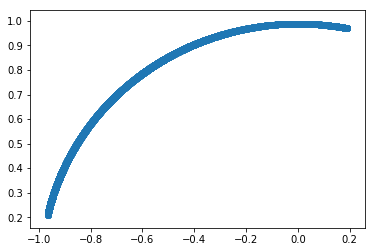

In [34]:
plt.scatter(train[train['group_id']==10]['X'], train[train['group_id']==10]['Y'])

In [33]:
train.head()

,series_id,X,Y,Z,W,X-Y,X-Z,X-W,Y-Z,Y-W,Z-W,arctan_XY,arctan_ZW,group_id
0,0,-0.75853,-0.63435,-0.10488,-0.10597,-0.12418,-0.65365,-0.65256,-0.52947,-0.52838,0.00109,-2.445113,-2.351025,13
1,0,-0.75853,-0.63434,-0.10490,-0.10600,-0.12419,-0.65363,-0.65253,-0.52944,-0.52834,0.00110,-2.445121,-2.350979,13
2,0,-0.75853,-0.63435,-0.10492,-0.10597,-0.12418,-0.65361,-0.65256,-0.52943,-0.52838,0.00105,-2.445113,-2.351216,13
3,0,-0.75852,-0.63436,-0.10495,-0.10597,-0.12416,-0.65357,-0.65255,-0.52941,-0.52839,0.00102,-2.445099,-2.351359,13
4,0,-0.75852,-0.63435,-0.10495,-0.10596,-0.12417,-0.65357,-0.65256,-0.52940,-0.52839,0.00101,-2.445106,-2.351406,13


In [ ]:
if train['arctan_XY']<0 and train['arctan_XY']!=

In [22]:
def feat_eng(df):
    data = pd.DataFrame()
    
    df_columns = df.columns[1:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        #data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        #data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        #data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        #data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        #data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        #data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [23]:
train = feat_eng(train)

100%|██████████| 16/16 [00:00<00:00, 26.28it/s]


In [24]:
train.head()

,X_mean,X_max,X_min,X_std,X_range,X_maxtoMin,Y_mean,Y_max,Y_min,Y_std,Y_range,Y_maxtoMin,Z_mean,Z_max,Z_min,Z_std,Z_range,Z_maxtoMin,W_mean,W_max,W_min,W_std,W_range,W_maxtoMin,X-Y_mean,X-Y_max,X-Y_min,X-Y_std,X-Y_range,X-Y_maxtoMin,X-Z_mean,X-Z_max,X-Z_min,X-Z_std,X-Z_range,X-Z_maxtoMin,X-W_mean,X-W_max,X-W_min,X-W_std,X-W_range,X-W_maxtoMin,Y-Z_mean,Y-Z_max,Y-Z_min,Y-Z_std,Y-Z_range,Y-Z_maxtoMin,Y-W_mean,Y-W_max,Y-W_min,Y-W_std,Y-W_range,Y-W_maxtoMin,Z-W_mean,Z-W_max,Z-W_min,Z-W_std,Z-W_range,Z-W_maxtoMin,arctan_XY_mean,arctan_XY_max,arctan_XY_min,arctan_XY_std,arctan_XY_range,arctan_XY_maxtoMin,arctan_ZW_mean,arctan_ZW_max,arctan_ZW_min,arctan_ZW_std,arctan_ZW_range,arctan_ZW_maxtoMin,sqrt_YZ_mean,sqrt_YZ_max,sqrt_YZ_min,sqrt_YZ_std,sqrt_YZ_range,sqrt_YZ_maxtoMin,sqrt_YW_mean,sqrt_YW_max,sqrt_YW_min,sqrt_YW_std,sqrt_YW_range,sqrt_YW_maxtoMin,arctan_XYZ_mean,arctan_XYZ_max,arctan_XYZ_min,arctan_XYZ_std,arctan_XYZ_range,arctan_XYZ_maxtoMin,arctan_XYW_mean,arctan_XYW_max,arctan_XYW_min,arctan_XYW_std,arctan_XYW_range,arctan_XYW_maxtoMin
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75822,-0.75953,0.000363,0.00131,0.998275,-0.634008,-0.63306,-0.63456,0.000471,0.00150,0.997636,-0.105474,-0.104610,-0.106140,0.000432,0.001530,0.985585,-0.106470,-0.105590,-0.107050,0.000389,0.001460,0.986362,-0.124658,-0.12370,-0.12647,0.000827,0.00277,0.978098,-0.653192,-0.652290,-0.654920,0.000619,0.002630,0.995984,-0.652196,-0.651520,-0.652920,0.000350,0.001400,0.997856,-0.528534,-0.527310,-0.529640,0.000648,0.002330,0.995601,-0.527538,-0.526140,-0.528860,0.000803,0.002720,0.994857,0.000995,0.002290,0.000410,0.000416,0.001880,5.585366,-2.445467,-2.444777,-2.446762,0.000596,0.001985,0.999189,-2.351497,-2.345371,-2.354262,0.001964,0.008891,0.996223,-0.642721,-0.641645,-0.643244,0.000468,0.001599,0.997514,-0.642885,-0.642012,-0.643395,0.000419,0.001383,0.997850,-2.438742,-2.438064,-2.440130,0.000594,0.002066,0.999153,-2.438616,-2.437942,-2.439848,0.000556,0.001905,0.999219
1,-0.958606,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.241867,0.24270,0.24074,0.000499,0.00196,1.008142,0.031650,0.032341,0.030504,0.000508,0.001837,1.060222,-0.146876,-0.145870,-0.148090,0.000521,0.002220,0.985009,-1.200473,-1.19964,-1.20114,0.000384,0.00150,0.998751,-0.990257,-0.989344,-0.990789,0.000390,0.001445,0.998542,-0.811731,-0.810310,-0.812800,0.000601,0.002490,0.996937,0.210217,0.211106,0.209557,0.000390,0.001549,1.007392,0.388743,0.390000,0.387320,0.000661,0.002680,1.006919,0.178526,0.180008,0.176544,0.000823,0.003464,1.019621,2.894440,2.895633,2.893570,0.000520,0.002063,1.000713,-1.358554,-1.353896,-1.364894,0.003188,0.010997,0.991943,0.243929,0.244845,0.242697,0.000543,0.002148,1.008852,0.282971,0.283717,0.281869,0.000467,0.001848,1.006556,2.892418,2.893714,2.891467,0.000564,0.002247,1.000777,2.854555,2.855712,2.853772,0.000491,0.001940,1.000680
2,-0.512057,-0.50944,-0.51434,0.001377,0.00490,0.990473,-0.846171,-0.84490,-0.84779,0.000785,0.00289,0.996591,-0.129371,-0.128520,-0.130300,0.000541,0.001780,0.986339,-0.071082,-0.070378,-0.071535,0.000278,0.001157,0.983826,0.334114,0.33835,0.33056,0.002160,0.00779,1.023566,-0.382687,-0.379530,-0.385780,0.001808,0.006250,0.983799,-0.440975,-0.438863,-0.443058,0.001309,0.004195,0.990532,-0.716800,-0.715810,-0.718330,0.000596,0.002520,0.996492,-0.775089,-0.773591,-0.777412,0.000939,0.003821,0.995085,-0.058289,-0.057278,-0.059375,0.000509,0.002097,0.964682,-2.114991,-2.111880,-2.117631,0.001601,0.005751,0.997284,-2.639174,-2.635328,-2.643796,0.001923,0.008468,0.996797,-0.856004,-0.854625,-0.857617,0.000832,0.002993,0.996511,-0.849151,-0.847902,-0.850706,0.000773,0.002805,0.996703,-2.109888,-2.106805,-2.112561,0.001613,0.005756,0.997275,-2.113435,-2.110365,-2.116057,0.001591,0.005692,0.997310
3,-0.939169,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.310140,0.31147,0.30943,0.000453,0.00204,1.006593,0.038955,0.039799,0.037922,0.000449,0.001877,1.049496,-

In [25]:
data_col = train.columns

In [26]:
for data in [train]:
    data.fillna(0,inplace=True)
    data.replace(-np.inf,0,inplace=True)
    data.replace(np.inf,0,inplace=True)

In [27]:
y_gr = y_train['group_id']

In [28]:
len(y_train['group_id'].value_counts())

73

In [34]:
N_SPLITS=4

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(train, y_gr))

clf = []
val_acc = []
val_pred = []
val_y = []

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': 73,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = np.asarray(train)[train_idx, :], y_gr[train_idx]
    X_val, y_val = np.asarray(train)[val_idx, :], y_gr[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    val_pred.append(pred_lgb)
    val_y.append(y_val)
    
    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

    clf.append(model_lgb)

[1]	valid_0's multi_logloss: 2.81267
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 2.56188
[3]	valid_0's multi_logloss: 2.38068
[4]	valid_0's multi_logloss: 2.23266
[5]	valid_0's multi_logloss: 2.11565
[6]	valid_0's multi_logloss: 2.01703
[7]	valid_0's multi_logloss: 1.93478
[8]	valid_0's multi_logloss: 1.86004
[9]	valid_0's multi_logloss: 1.79498
[10]	valid_0's multi_logloss: 1.73709
[11]	valid_0's multi_logloss: 1.68357
[12]	valid_0's multi_logloss: 1.63836
[13]	valid_0's multi_logloss: 1.59389
[14]	valid_0's multi_logloss: 1.5566
[15]	valid_0's multi_logloss: 1.5216
[16]	valid_0's multi_logloss: 1.49026
[17]	valid_0's multi_logloss: 1.45919
[18]	valid_0's multi_logloss: 1.43209
[19]	valid_0's multi_logloss: 1.40824
[20]	valid_0's multi_logloss: 1.38625
[21]	valid_0's multi_logloss: 1.36526
[22]	valid_0's multi_logloss: 1.34736
[23]	valid_0's multi_logloss: 1.32972
[24]	valid_0's multi_logloss: 1.31361
[25]	valid_0's multi_logloss: 1.29927

[47]	valid_0's multi_logloss: 1.10261
[48]	valid_0's multi_logloss: 1.10168
[49]	valid_0's multi_logloss: 1.10031
[50]	valid_0's multi_logloss: 1.10171
[51]	valid_0's multi_logloss: 1.1021
[52]	valid_0's multi_logloss: 1.10301
[53]	valid_0's multi_logloss: 1.10354
[54]	valid_0's multi_logloss: 1.10536
[55]	valid_0's multi_logloss: 1.10555
[56]	valid_0's multi_logloss: 1.10501
[57]	valid_0's multi_logloss: 1.10519
[58]	valid_0's multi_logloss: 1.1076
[59]	valid_0's multi_logloss: 1.11026
[60]	valid_0's multi_logloss: 1.11262
[61]	valid_0's multi_logloss: 1.114
[62]	valid_0's multi_logloss: 1.11449
[63]	valid_0's multi_logloss: 1.11772
[64]	valid_0's multi_logloss: 1.1203
[65]	valid_0's multi_logloss: 1.12213
[66]	valid_0's multi_logloss: 1.12395
[67]	valid_0's multi_logloss: 1.12516
[68]	valid_0's multi_logloss: 1.1278
[69]	valid_0's multi_logloss: 1.1303
[70]	valid_0's multi_logloss: 1.13137
[71]	valid_0's multi_logloss: 1.13319
[72]	valid_0's multi_logloss: 1.13688
[73]	valid_0's mult

In [35]:
val_acc

[0.6734279918864098,
 0.6833333333333333,
 0.6858974358974359,
 0.6573275862068966]

In [36]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=data_col).sort_values(by=0, ascending=False)

,0
X-Z_min,3923.620784
Z-W_min,3661.962580
arctan_ZW_mean,3605.676845
Z_min,3507.920893
Z-W_max,3460.019421
X-Y_max,3305.326035
Y-W_min,3299.082436
X-Y_min,3218.361602
X-Z_max,2912.127883
Y-W_max,2912.053817


In [37]:
pd.concat([pd.Series(val_y[0]).reset_index()['group_id'], pd.Series(np.argmax(val_pred[0], axis=1))], axis=1)

,group_id,0
0,31,31
1,11,11
2,33,33
3,9,9
4,13,13
5,27,27
6,32,32
7,9,43
8,20,20
9,22,22


In [39]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
N_SPLITS = 5

In [41]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [43]:
y = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_test))), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

In [44]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

clf_2 = []
val_roc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'binary_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary',
               #'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in splits:
    X_tr, y_tr = X[train_idx, :], y[train_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    
    val_roc.append(roc_auc_score(y_val, (pred_lgb>0.5).astype(int)))
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=0)
    
    clf_2.append(model_lgb)

[1]	valid_0's binary_logloss: 0.677142
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.665079
[3]	valid_0's binary_logloss: 0.654526
[4]	valid_0's binary_logloss: 0.645017
[5]	valid_0's binary_logloss: 0.636375
[6]	valid_0's binary_logloss: 0.628653
[7]	valid_0's binary_logloss: 0.622474
[8]	valid_0's binary_logloss: 0.615707
[9]	valid_0's binary_logloss: 0.610228
[10]	valid_0's binary_logloss: 0.604597
[11]	valid_0's binary_logloss: 0.600152
[12]	valid_0's binary_logloss: 0.59576
[13]	valid_0's binary_logloss: 0.590724
[14]	valid_0's binary_logloss: 0.586489
[15]	valid_0's binary_logloss: 0.581511
[16]	valid_0's binary_logloss: 0.576641
[17]	valid_0's binary_logloss: 0.57431
[18]	valid_0's binary_logloss: 0.571321
[19]	valid_0's binary_logloss: 0.569197
[20]	valid_0's binary_logloss: 0.566383
[21]	valid_0's binary_logloss: 0.563259
[22]	valid_0's binary_logloss: 0.559394
[23]	valid_0's binary_logloss: 0.556917
[24]	valid_0's binary_logloss

[230]	valid_0's binary_logloss: 0.44341
[231]	valid_0's binary_logloss: 0.443406
[232]	valid_0's binary_logloss: 0.443203
[233]	valid_0's binary_logloss: 0.443446
[234]	valid_0's binary_logloss: 0.443757
[235]	valid_0's binary_logloss: 0.444005
[236]	valid_0's binary_logloss: 0.444027
[237]	valid_0's binary_logloss: 0.44388
[238]	valid_0's binary_logloss: 0.443131
[239]	valid_0's binary_logloss: 0.443107
[240]	valid_0's binary_logloss: 0.443162
[241]	valid_0's binary_logloss: 0.442885
[242]	valid_0's binary_logloss: 0.442871
[243]	valid_0's binary_logloss: 0.44328
[244]	valid_0's binary_logloss: 0.442956
[245]	valid_0's binary_logloss: 0.443092
[246]	valid_0's binary_logloss: 0.443445
[247]	valid_0's binary_logloss: 0.443611
[248]	valid_0's binary_logloss: 0.44395
[249]	valid_0's binary_logloss: 0.443551
[250]	valid_0's binary_logloss: 0.443592
[251]	valid_0's binary_logloss: 0.443341
[252]	valid_0's binary_logloss: 0.443114
[253]	valid_0's binary_logloss: 0.443328
[254]	valid_0's bina

[455]	valid_0's binary_logloss: 0.426328
[456]	valid_0's binary_logloss: 0.426885
[457]	valid_0's binary_logloss: 0.426102
[458]	valid_0's binary_logloss: 0.426181
[459]	valid_0's binary_logloss: 0.426287
[460]	valid_0's binary_logloss: 0.426559
[461]	valid_0's binary_logloss: 0.426409
[462]	valid_0's binary_logloss: 0.426291
[463]	valid_0's binary_logloss: 0.42612
[464]	valid_0's binary_logloss: 0.426608
[465]	valid_0's binary_logloss: 0.426219
[466]	valid_0's binary_logloss: 0.426356
[467]	valid_0's binary_logloss: 0.426231
[468]	valid_0's binary_logloss: 0.426205
[469]	valid_0's binary_logloss: 0.426497
[470]	valid_0's binary_logloss: 0.426613
[471]	valid_0's binary_logloss: 0.426444
[472]	valid_0's binary_logloss: 0.426836
[473]	valid_0's binary_logloss: 0.426567
[474]	valid_0's binary_logloss: 0.426374
[475]	valid_0's binary_logloss: 0.426341
[476]	valid_0's binary_logloss: 0.426597
[477]	valid_0's binary_logloss: 0.426134
[478]	valid_0's binary_logloss: 0.426596
[479]	valid_0's b

[197]	valid_0's binary_logloss: 0.472162
[198]	valid_0's binary_logloss: 0.472597
[199]	valid_0's binary_logloss: 0.472078
[200]	valid_0's binary_logloss: 0.471094
[201]	valid_0's binary_logloss: 0.470839
[202]	valid_0's binary_logloss: 0.470568
[203]	valid_0's binary_logloss: 0.47069
[204]	valid_0's binary_logloss: 0.470897
[205]	valid_0's binary_logloss: 0.471232
[206]	valid_0's binary_logloss: 0.471365
[207]	valid_0's binary_logloss: 0.471115
[208]	valid_0's binary_logloss: 0.470625
[209]	valid_0's binary_logloss: 0.469771
[210]	valid_0's binary_logloss: 0.469212
[211]	valid_0's binary_logloss: 0.468787
[212]	valid_0's binary_logloss: 0.469014
[213]	valid_0's binary_logloss: 0.468735
[214]	valid_0's binary_logloss: 0.467133
[215]	valid_0's binary_logloss: 0.466954
[216]	valid_0's binary_logloss: 0.466747
[217]	valid_0's binary_logloss: 0.46642
[218]	valid_0's binary_logloss: 0.466718
[219]	valid_0's binary_logloss: 0.466497
[220]	valid_0's binary_logloss: 0.465263
[221]	valid_0's bi

[29]	valid_0's binary_logloss: 0.556411
[30]	valid_0's binary_logloss: 0.554938
[31]	valid_0's binary_logloss: 0.552433
[32]	valid_0's binary_logloss: 0.550615
[33]	valid_0's binary_logloss: 0.549591
[34]	valid_0's binary_logloss: 0.549148
[35]	valid_0's binary_logloss: 0.547284
[36]	valid_0's binary_logloss: 0.546036
[37]	valid_0's binary_logloss: 0.544941
[38]	valid_0's binary_logloss: 0.543246
[39]	valid_0's binary_logloss: 0.541794
[40]	valid_0's binary_logloss: 0.541014
[41]	valid_0's binary_logloss: 0.540583
[42]	valid_0's binary_logloss: 0.538709
[43]	valid_0's binary_logloss: 0.537882
[44]	valid_0's binary_logloss: 0.537882
[45]	valid_0's binary_logloss: 0.536761
[46]	valid_0's binary_logloss: 0.535542
[47]	valid_0's binary_logloss: 0.533752
[48]	valid_0's binary_logloss: 0.532892
[49]	valid_0's binary_logloss: 0.529998
[50]	valid_0's binary_logloss: 0.528578
[51]	valid_0's binary_logloss: 0.527725
[52]	valid_0's binary_logloss: 0.527697
[53]	valid_0's binary_logloss: 0.526623


[235]	valid_0's binary_logloss: 0.469732
[236]	valid_0's binary_logloss: 0.469847
[237]	valid_0's binary_logloss: 0.469092
[238]	valid_0's binary_logloss: 0.468825
[239]	valid_0's binary_logloss: 0.468924
[240]	valid_0's binary_logloss: 0.469066
[241]	valid_0's binary_logloss: 0.468921
[242]	valid_0's binary_logloss: 0.469159
[243]	valid_0's binary_logloss: 0.469277
[244]	valid_0's binary_logloss: 0.469254
[245]	valid_0's binary_logloss: 0.469135
[246]	valid_0's binary_logloss: 0.468141
[247]	valid_0's binary_logloss: 0.468416
[248]	valid_0's binary_logloss: 0.468493
[249]	valid_0's binary_logloss: 0.468164
[250]	valid_0's binary_logloss: 0.468172
[251]	valid_0's binary_logloss: 0.467779
[252]	valid_0's binary_logloss: 0.467553
[253]	valid_0's binary_logloss: 0.467592
[254]	valid_0's binary_logloss: 0.468078
[255]	valid_0's binary_logloss: 0.467624
[256]	valid_0's binary_logloss: 0.467622
[257]	valid_0's binary_logloss: 0.467248
[258]	valid_0's binary_logloss: 0.467119
[259]	valid_0's 

[66]	valid_0's binary_logloss: 0.492452
[67]	valid_0's binary_logloss: 0.49256
[68]	valid_0's binary_logloss: 0.491484
[69]	valid_0's binary_logloss: 0.491099
[70]	valid_0's binary_logloss: 0.48981
[71]	valid_0's binary_logloss: 0.489582
[72]	valid_0's binary_logloss: 0.489479
[73]	valid_0's binary_logloss: 0.489752
[74]	valid_0's binary_logloss: 0.489658
[75]	valid_0's binary_logloss: 0.489112
[76]	valid_0's binary_logloss: 0.488429
[77]	valid_0's binary_logloss: 0.488051
[78]	valid_0's binary_logloss: 0.487666
[79]	valid_0's binary_logloss: 0.487076
[80]	valid_0's binary_logloss: 0.487428
[81]	valid_0's binary_logloss: 0.486723
[82]	valid_0's binary_logloss: 0.486507
[83]	valid_0's binary_logloss: 0.485428
[84]	valid_0's binary_logloss: 0.485576
[85]	valid_0's binary_logloss: 0.484592
[86]	valid_0's binary_logloss: 0.484514
[87]	valid_0's binary_logloss: 0.484975
[88]	valid_0's binary_logloss: 0.48313
[89]	valid_0's binary_logloss: 0.482315
[90]	valid_0's binary_logloss: 0.482441
[91

[276]	valid_0's binary_logloss: 0.440382
[277]	valid_0's binary_logloss: 0.440283
[278]	valid_0's binary_logloss: 0.440003
[279]	valid_0's binary_logloss: 0.439817
[280]	valid_0's binary_logloss: 0.439316
[281]	valid_0's binary_logloss: 0.439144
[282]	valid_0's binary_logloss: 0.439159
[283]	valid_0's binary_logloss: 0.438802
[284]	valid_0's binary_logloss: 0.438686
[285]	valid_0's binary_logloss: 0.438988
[286]	valid_0's binary_logloss: 0.438463
[287]	valid_0's binary_logloss: 0.438469
[288]	valid_0's binary_logloss: 0.438639
[289]	valid_0's binary_logloss: 0.438531
[290]	valid_0's binary_logloss: 0.438681
[291]	valid_0's binary_logloss: 0.438825
[292]	valid_0's binary_logloss: 0.438686
[293]	valid_0's binary_logloss: 0.438517
[294]	valid_0's binary_logloss: 0.438619
[295]	valid_0's binary_logloss: 0.438793
[296]	valid_0's binary_logloss: 0.438915
[297]	valid_0's binary_logloss: 0.438841
[298]	valid_0's binary_logloss: 0.438428
[299]	valid_0's binary_logloss: 0.43837
[300]	valid_0's b

[121]	valid_0's binary_logloss: 0.471989
[122]	valid_0's binary_logloss: 0.471774
[123]	valid_0's binary_logloss: 0.47167
[124]	valid_0's binary_logloss: 0.471287
[125]	valid_0's binary_logloss: 0.470836
[126]	valid_0's binary_logloss: 0.469961
[127]	valid_0's binary_logloss: 0.46907
[128]	valid_0's binary_logloss: 0.468047
[129]	valid_0's binary_logloss: 0.467704
[130]	valid_0's binary_logloss: 0.467804
[131]	valid_0's binary_logloss: 0.467932
[132]	valid_0's binary_logloss: 0.466712
[133]	valid_0's binary_logloss: 0.466357
[134]	valid_0's binary_logloss: 0.466514
[135]	valid_0's binary_logloss: 0.466445
[136]	valid_0's binary_logloss: 0.466196
[137]	valid_0's binary_logloss: 0.466089
[138]	valid_0's binary_logloss: 0.465858
[139]	valid_0's binary_logloss: 0.464109
[140]	valid_0's binary_logloss: 0.464218
[141]	valid_0's binary_logloss: 0.464479
[142]	valid_0's binary_logloss: 0.464637
[143]	valid_0's binary_logloss: 0.46412
[144]	valid_0's binary_logloss: 0.463885
[145]	valid_0's bin

[355]	valid_0's binary_logloss: 0.428104
[356]	valid_0's binary_logloss: 0.428113
[357]	valid_0's binary_logloss: 0.428298
[358]	valid_0's binary_logloss: 0.4281
[359]	valid_0's binary_logloss: 0.427961
[360]	valid_0's binary_logloss: 0.427327
[361]	valid_0's binary_logloss: 0.426425
[362]	valid_0's binary_logloss: 0.426191
[363]	valid_0's binary_logloss: 0.425731
[364]	valid_0's binary_logloss: 0.425411
[365]	valid_0's binary_logloss: 0.425331
[366]	valid_0's binary_logloss: 0.424863
[367]	valid_0's binary_logloss: 0.424163
[368]	valid_0's binary_logloss: 0.424213
[369]	valid_0's binary_logloss: 0.424136
[370]	valid_0's binary_logloss: 0.424199
[371]	valid_0's binary_logloss: 0.424389
[372]	valid_0's binary_logloss: 0.424237
[373]	valid_0's binary_logloss: 0.424064
[374]	valid_0's binary_logloss: 0.424073
[375]	valid_0's binary_logloss: 0.42408
[376]	valid_0's binary_logloss: 0.424167
[377]	valid_0's binary_logloss: 0.424177
[378]	valid_0's binary_logloss: 0.423901
[379]	valid_0's bin

In [45]:
val_roc

[0.8007740033804676,
 0.7744149527180662,
 0.7717894208178105,
 0.8052453879044936,
 0.8098299639150611]

In [46]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf_2:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=data_col).sort_values(by=0, ascending=False)

,0
euler_X_min,4555.401027
orientation_X_max,3010.485054
orientation_X_min,2900.974315
euler_Y_min,2881.295440
orientation_X_mean,2860.740595
euler_X_max,2754.423669
orientation_Z_max,2662.875396
orientation_Z_abs_max,2554.616806
orientation_Y_min,2451.427175
euler_Z_max,2421.282313


In [47]:
adv_val = []
for model in clf_2:
    adv_val.append(model.predict(X_train))

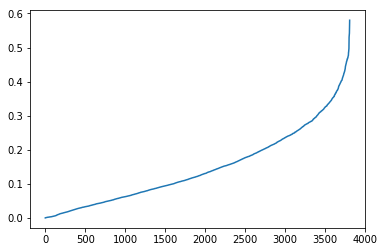

In [48]:
plt.plot(np.sort(np.mean(adv_val, axis=0)))

In [49]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_train, y_id))

clf = []
val_acc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = X_train[train_idx, :], y_id[train_idx]
    X_val, y_val = X_train[val_idx, :], y_id[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)

    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

clf.append(model_lgb)

[1]	valid_0's multi_logloss: 1.77624
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.61589
[3]	valid_0's multi_logloss: 1.48848
[4]	valid_0's multi_logloss: 1.38419
[5]	valid_0's multi_logloss: 1.29528
[6]	valid_0's multi_logloss: 1.21675
[7]	valid_0's multi_logloss: 1.14872
[8]	valid_0's multi_logloss: 1.08529
[9]	valid_0's multi_logloss: 1.03025
[10]	valid_0's multi_logloss: 0.977928
[11]	valid_0's multi_logloss: 0.932958
[12]	valid_0's multi_logloss: 0.893463
[13]	valid_0's multi_logloss: 0.854346
[14]	valid_0's multi_logloss: 0.821053
[15]	valid_0's multi_logloss: 0.786741
[16]	valid_0's multi_logloss: 0.759278
[17]	valid_0's multi_logloss: 0.733458
[18]	valid_0's multi_logloss: 0.709332
[19]	valid_0's multi_logloss: 0.685646
[20]	valid_0's multi_logloss: 0.665403
[21]	valid_0's multi_logloss: 0.644428
[22]	valid_0's multi_logloss: 0.624543
[23]	valid_0's multi_logloss: 0.606643
[24]	valid_0's multi_logloss: 0.590151
[25]	valid_0's multi

[34]	valid_0's multi_logloss: 0.430732
[35]	valid_0's multi_logloss: 0.422478
[36]	valid_0's multi_logloss: 0.414529
[37]	valid_0's multi_logloss: 0.405909
[38]	valid_0's multi_logloss: 0.398548
[39]	valid_0's multi_logloss: 0.390954
[40]	valid_0's multi_logloss: 0.383582
[41]	valid_0's multi_logloss: 0.377474
[42]	valid_0's multi_logloss: 0.371173
[43]	valid_0's multi_logloss: 0.366142
[44]	valid_0's multi_logloss: 0.360234
[45]	valid_0's multi_logloss: 0.355173
[46]	valid_0's multi_logloss: 0.349224
[47]	valid_0's multi_logloss: 0.344702
[48]	valid_0's multi_logloss: 0.340975
[49]	valid_0's multi_logloss: 0.336052
[50]	valid_0's multi_logloss: 0.332452
[51]	valid_0's multi_logloss: 0.328634
[52]	valid_0's multi_logloss: 0.325719
[53]	valid_0's multi_logloss: 0.32098
[54]	valid_0's multi_logloss: 0.318186
[55]	valid_0's multi_logloss: 0.314782
[56]	valid_0's multi_logloss: 0.311464
[57]	valid_0's multi_logloss: 0.308312
[58]	valid_0's multi_logloss: 0.3052
[59]	valid_0's multi_logloss

[21]	valid_0's multi_logloss: 0.639083
[22]	valid_0's multi_logloss: 0.622075
[23]	valid_0's multi_logloss: 0.605609
[24]	valid_0's multi_logloss: 0.589715
[25]	valid_0's multi_logloss: 0.573761
[26]	valid_0's multi_logloss: 0.559451
[27]	valid_0's multi_logloss: 0.545482
[28]	valid_0's multi_logloss: 0.532261
[29]	valid_0's multi_logloss: 0.518552
[30]	valid_0's multi_logloss: 0.506651
[31]	valid_0's multi_logloss: 0.494855
[32]	valid_0's multi_logloss: 0.485286
[33]	valid_0's multi_logloss: 0.476719
[34]	valid_0's multi_logloss: 0.467915
[35]	valid_0's multi_logloss: 0.459651
[36]	valid_0's multi_logloss: 0.452064
[37]	valid_0's multi_logloss: 0.443003
[38]	valid_0's multi_logloss: 0.434557
[39]	valid_0's multi_logloss: 0.426877
[40]	valid_0's multi_logloss: 0.419955
[41]	valid_0's multi_logloss: 0.414221
[42]	valid_0's multi_logloss: 0.407997
[43]	valid_0's multi_logloss: 0.402413
[44]	valid_0's multi_logloss: 0.396987
[45]	valid_0's multi_logloss: 0.391046
[46]	valid_0's multi_logl

[47]	valid_0's multi_logloss: 0.381579
[48]	valid_0's multi_logloss: 0.376295
[49]	valid_0's multi_logloss: 0.37071
[50]	valid_0's multi_logloss: 0.366738
[51]	valid_0's multi_logloss: 0.362678
[52]	valid_0's multi_logloss: 0.359082
[53]	valid_0's multi_logloss: 0.354592
[54]	valid_0's multi_logloss: 0.350888
[55]	valid_0's multi_logloss: 0.347234
[56]	valid_0's multi_logloss: 0.342431
[57]	valid_0's multi_logloss: 0.338936
[58]	valid_0's multi_logloss: 0.336734
[59]	valid_0's multi_logloss: 0.333732
[60]	valid_0's multi_logloss: 0.330007
[61]	valid_0's multi_logloss: 0.326943
[62]	valid_0's multi_logloss: 0.324801
[63]	valid_0's multi_logloss: 0.321535
[64]	valid_0's multi_logloss: 0.319162
[65]	valid_0's multi_logloss: 0.316698
[66]	valid_0's multi_logloss: 0.314283
[67]	valid_0's multi_logloss: 0.312973
[68]	valid_0's multi_logloss: 0.311284
[69]	valid_0's multi_logloss: 0.309298
[70]	valid_0's multi_logloss: 0.306997
[71]	valid_0's multi_logloss: 0.305086
[72]	valid_0's multi_loglo

[86]	valid_0's multi_logloss: 0.24144
[87]	valid_0's multi_logloss: 0.239799
[88]	valid_0's multi_logloss: 0.238948
[89]	valid_0's multi_logloss: 0.237766
[90]	valid_0's multi_logloss: 0.23749
[91]	valid_0's multi_logloss: 0.236907
[92]	valid_0's multi_logloss: 0.236088
[93]	valid_0's multi_logloss: 0.235165
[94]	valid_0's multi_logloss: 0.233819
[95]	valid_0's multi_logloss: 0.232626
[96]	valid_0's multi_logloss: 0.231237
[97]	valid_0's multi_logloss: 0.230294
[98]	valid_0's multi_logloss: 0.229078
[99]	valid_0's multi_logloss: 0.228202
[100]	valid_0's multi_logloss: 0.227567
[101]	valid_0's multi_logloss: 0.227151
[102]	valid_0's multi_logloss: 0.22671
[103]	valid_0's multi_logloss: 0.226233
[104]	valid_0's multi_logloss: 0.224853
[105]	valid_0's multi_logloss: 0.225522
[106]	valid_0's multi_logloss: 0.224668
[107]	valid_0's multi_logloss: 0.224452
[108]	valid_0's multi_logloss: 0.223841
[109]	valid_0's multi_logloss: 0.223694
[110]	valid_0's multi_logloss: 0.223464
[111]	valid_0's m

In [50]:
val_acc

[0.9099216710182768,
 0.9320261437908497,
 0.9291338582677166,
 0.9105263157894737,
 0.9431968295904888]

In [51]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=data_col).sort_values(by=0, ascending=False)

,0
linear_acceleration_X_mean_abs_chg,2.829803e+03
total_ang_cos_mean_abs_chg,2.633236e+03
total_acce_mean_abs_chg,2.003432e+03
angular_velocity_Y_mean_abs_chg,1.940931e+03
orientation_X_mean,1.692677e+03
orientation_X_min,1.651059e+03
orientation_X_max,1.575824e+03
angular_velocity_Z_min,1.485777e+03
euler_Z_mean,1.369278e+03
linear_acceleration_Y_mean_abs_chg,1.337735e+03


In [ ]:
preds_test = []

for model in clf:
    preds_test.append(model.predict(X_test))

In [ ]:
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [ ]:
test_surface = []
for i in preds_test:
    test_surface.append(id_to_target[i])

In [ ]:
test_surface = np.asarray(test_surface)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')

In [ ]:
submission['surface'] = test_surface
submission.to_csv('../output/submission_1.csv', index=False)
submission.head()